In [1]:
import numpy as np
from sklearn import datasets
import sys
sys.path.append('..')
from sklearn.decomposition import PCA
from Tesi.resurces.FDA import KPCA_FDA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler 

from sklearn.model_selection import GridSearchCV

In [2]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.45)
face_data = lfw_people['data']
face_images = lfw_people['images']
face_tnames = lfw_people['target_names']
face_targets = lfw_people['target']

# Creare gli X_trainval, y_trainval, X_test, y_test
#5890
random_state = 19990704 #np.random.randint(0, 100000)
print('random_seed = ', random_state)
test_p = 0.4
#val_p = 0.25  # Percentuale di dati di X_trainval da usare come validation set

X_trainval, X_test, y_trainval, y_test, _, img_test = train_test_split(face_data, face_targets, face_images, test_size=test_p, random_state=random_state, shuffle=True)

ros = RandomOverSampler(random_state= random_state)
X_trainval_ros, y_trainval_ros = ros.fit_resample(X_trainval, y_trainval)

random_seed =  19990704


In [3]:
parameters = {
    'fda_components': [4],
    'kernel':['rbf', 'poly', 'sigmoid', 'cosine'], #possibili Kernel tra quelli da testare nelle performance
    'k_degree':[3, 4, 5],
    'k_gamma':[None],
    'k_coef0':[0.55, 0.6, 0.65, 0.7]}
fda_grid = KPCA_FDA() #Nuova funzione che ha all'interno entrambe le trasformazioni
clf = GridSearchCV(fda_grid, parameters, error_score='raise')
clf.fit(X_trainval, y_trainval, error_score='raise')

clf_ros = GridSearchCV(fda_grid, parameters, error_score='raise')
clf_ros.fit(X_trainval_ros, y_trainval_ros, error_score='raise')

print(clf.best_params_)
print(clf_ros.best_params_)
clf_risults = pd.DataFrame(clf.cv_results_)[['mean_fit_time', 'param_k_coef0', 'param_k_degree', 'param_kernel','mean_test_score', 'rank_test_score']]
display(clf_risults.sort_values(by=['rank_test_score'])[0:7])
clf_risults_ros = pd.DataFrame(clf_ros.cv_results_)[['mean_fit_time', 'param_k_coef0', 'param_k_degree', 'param_kernel','mean_test_score', 'rank_test_score']]
display(clf_risults_ros.sort_values(by=['rank_test_score'])[0:7])

{'fda_components': 4, 'k_coef0': 0.6, 'k_degree': 3, 'k_gamma': None, 'kernel': 'poly'}
{'fda_components': 4, 'k_coef0': 0.55, 'k_degree': 3, 'k_gamma': None, 'kernel': 'rbf'}


,mean_fit_time,param_k_coef0,param_k_degree,param_kernel,mean_test_score,rank_test_score
13,0.796873,0.6,3,poly,0.827426,1
1,0.899133,0.55,3,poly,0.824495,2
25,1.181000,0.65,3,poly,0.820105,3
41,0.826723,0.7,4,poly,0.820094,4
17,0.728259,0.6,4,poly,0.820094,4
37,0.711849,0.7,3,poly,0.818645,6
29,0.855838,0.65,4,poly,0.818635,7


,mean_fit_time,param_k_coef0,param_k_degree,param_kernel,mean_test_score,rank_test_score
0,4.440643,0.55,3,rbf,0.962382,1
20,4.912956,0.6,5,rbf,0.962382,1
28,4.830205,0.65,4,rbf,0.962382,1
16,5.430690,0.6,4,rbf,0.962382,1
32,5.027067,0.65,5,rbf,0.962382,1
12,5.526649,0.6,3,rbf,0.962382,1
36,4.820720,0.7,3,rbf,0.962382,1


,Accuracy,Precision,Recall,F1
Training Set,1.000000,1.000000,1.000000,1.000000
Test Set,0.813596,0.811830,0.813596,0.806923
Oversampling Training Set,1.000000,1.000000,1.000000,1.000000
Oversampling Test Set,0.833333,0.833343,0.833333,0.828308


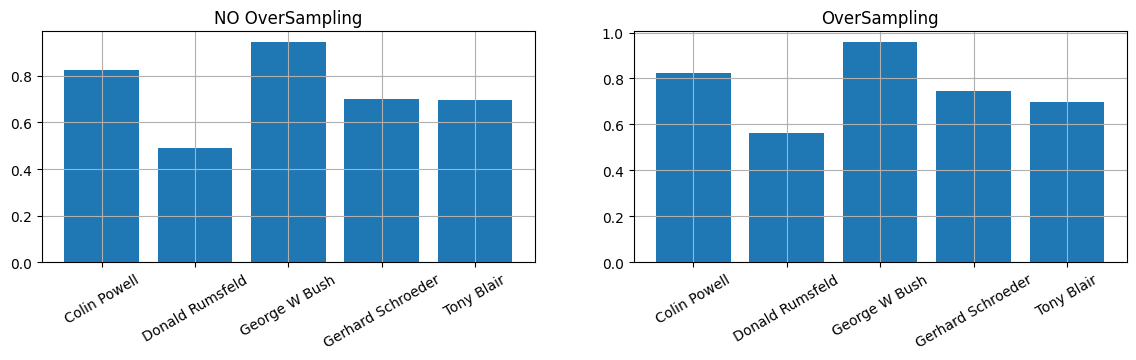

In [6]:
#FDA

#normal
kpca_fda = KPCA_FDA(**clf.best_params_)
kpca_fda.fit(X_trainval, y_trainval)

#oversampled
kpca_fda_ros = KPCA_FDA(**clf_ros.best_params_) #migliori parametri trovati per il Random Oversampling
kpca_fda_ros.fit(X_trainval_ros, y_trainval_ros)


y_p = kpca_fda.predict(X_test)
y_p_t = kpca_fda.predict(X_trainval)

a_t = kpca_fda.score(X_trainval, y_trainval) #accuracy train
p_t = precision_score(y_trainval, y_p_t, average='weighted', zero_division=0) #precision train
r_t = recall_score(y_trainval, y_p_t, average='weighted') #recall train
f1_t = f1_score(y_trainval, y_p_t, average='weighted') #f1 train

a = kpca_fda.score(X_test, y_test) #accuracy
p = precision_score(y_test, y_p, average='weighted', zero_division=0) #precision
r = recall_score(y_test, y_p, average='weighted') #recall
f1 = f1_score(y_test, y_p, average='weighted') #f1

df_p = pd.DataFrame({ 'Accuracy': [a_t, a],
                        'Precision': [p_t, p], 
                        'Recall': [r_t, r],
                        'F1': [f1_t, f1]
                       },
                      index=['Training Set', 'Test Set'])

y_p_ros = kpca_fda_ros.predict(X_test)
y_p_t_ros = kpca_fda_ros.predict(X_trainval_ros)

a_t_ros = kpca_fda_ros.score(X_trainval_ros, y_trainval_ros) #accuracy train
p_t_ros = precision_score(y_trainval_ros, y_p_t_ros, average='weighted', zero_division=0) #precision train
r_t_ros = recall_score(y_trainval_ros, y_p_t_ros, average='weighted') #recall train
f1_t_ros = f1_score(y_trainval_ros, y_p_t_ros, average='weighted') #f1 train

a_ros = kpca_fda_ros.score(X_test, y_test) #accuracy
p_ros = precision_score(y_test, y_p_ros, average='weighted', zero_division=0) #precision
r_ros = recall_score(y_test, y_p_ros, average='weighted') #recall
f1_ros = f1_score(y_test, y_p_ros, average='weighted') #f1

df_p_ros = pd.DataFrame({ 'Accuracy': [a_t_ros, a_ros],
                        'Precision': [p_t_ros, p_ros], 
                        'Recall': [r_t_ros, r_ros],
                        'F1': [f1_t_ros, f1_ros]
                       },
                      index=['Oversampling Training Set', 'Oversampling Test Set'])

display(pd.concat([df_p, df_p_ros]))

cmat_kfda = confusion_matrix(y_test, y_p)
cmat_kfda_ros = confusion_matrix(y_test, y_p_ros)

cmat_kfda_norm_true = confusion_matrix(y_test, y_p, normalize='true')
cmat_kfda_ros_norm_true = confusion_matrix(y_test, y_p_ros, normalize='true')

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].set_title('NO OverSampling')

axs[0].bar(np.arange(len(face_tnames)), [cmat_kfda_norm_true[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=30)
axs[0].grid()

axs[1].set_title('OverSampling')

axs[1].bar(np.arange(len(face_tnames)), [cmat_kfda_ros_norm_true[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=30)
axs[1].grid()

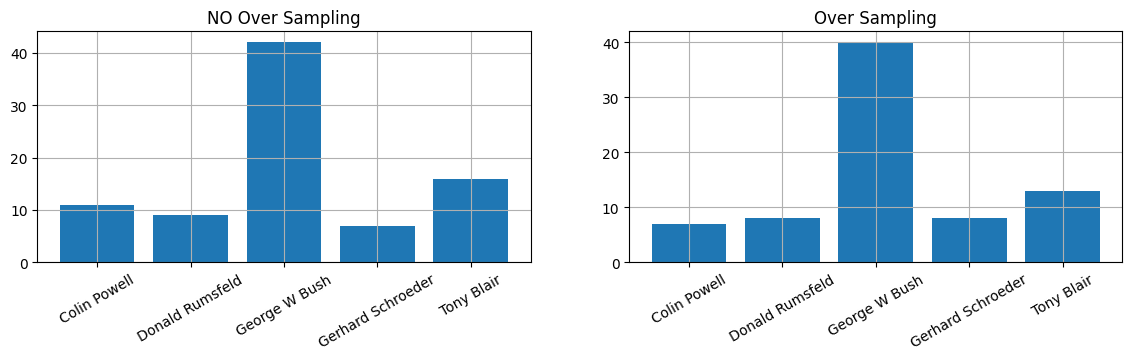

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].set_title('NO Over Sampling')

axs[0].bar(np.arange(len(face_tnames)), [np.sum(cmat_kfda[:,t]) -cmat_kfda[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=30)
axs[0].grid()

axs[1].set_title('Over Sampling')

axs[1].bar(np.arange(len(face_tnames)), [np.sum(cmat_kfda_ros[:,t]) -cmat_kfda_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=30)
axs[1].grid()

plt.show()